<a href="https://colab.research.google.com/github/Diishasing/Alzheimer-s-Disease-Classification-using-Deep-CNNs./blob/main/Alzheimer_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount= True)

Mounted at /content/gdrive/


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 200
INPUT_SHAPE = (64, 200, 200, 3)
n_class = 4

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Alzheimer_s_Dataset/train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5121 files belonging to 4 classes.


In [5]:
CLASSES = dataset.class_names
print(CLASSES)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
len(dataset)

81

In [7]:
for image, label in dataset.take(1):
  print(image.shape)
  print(CLASSES[label[0]])

(64, 200, 200, 3)
NonDemented


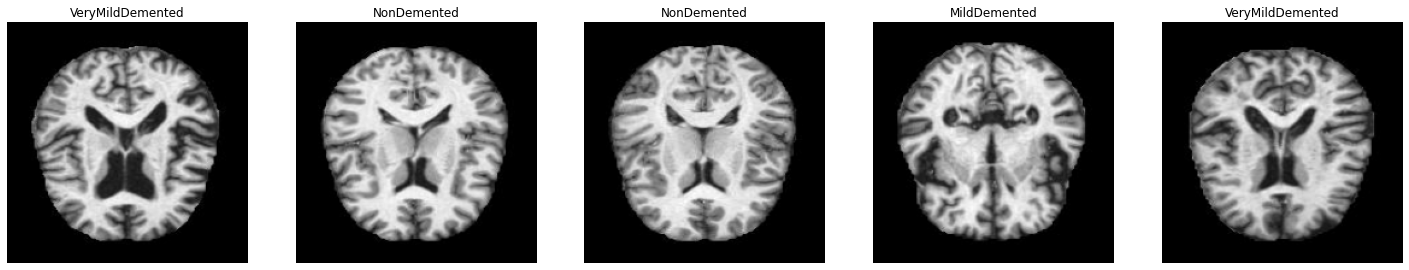

In [8]:
plt.figure(figsize = (25, 15))
for image, label in dataset.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(CLASSES[label[i]])
    plt.axis('off')

In [9]:
def data_partition(data, train_split = 0.7, val_split = 0.2, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size, seed = 23)

  train_size = int(train_split * ds)
  val_size = int(val_split * ds)

  train_data = data.take(train_size)
  val_data = data.skip(train_size).take(val_size)
  test_data = data.skip(train_size).skip(val_size)

  return train_data, val_data, test_data

In [10]:
train_data, val_data, test_data = data_partition(dataset)
print(f"{len(train_data)},{len(val_data)},{len(test_data)}")

56,16,9


In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [12]:
def optimize(data, shuffle = False):
  
  if shuffle:
    data = data.shuffle(1000, seed = 23)

  #using buffered prefetching on all the datasets for optimization
  return data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)    


In [13]:
train_data = optimize(train_data, shuffle = True)
val_data = optimize(val_data)
test_data = optimize(test_data)

In [14]:
model = tf.keras.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(16, input_shape= INPUT_SHAPE, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation = 'softmax'),
    ])

In [15]:
model.build(input_shape = INPUT_SHAPE)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 200, 200, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 200, 200, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 100, 100, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 100, 100, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (64, 100, 100, 64)        18496     
                                                                 
 dropout (Dropout)           (64, 100, 100, 64)        0         
                                                      

In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate =0.00001),
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy'],)

In [18]:
history = model.fit(train_data, 
                    epochs=75,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    validation_data = val_data)

Epoch 1/75
56/56 [==============================] - 615s 240ms/step - loss: 1.5133 - accuracy: 0.3695 - val_loss: 1.0448 - val_accuracy: 0.5671
Epoch 2/75
56/56 [==============================] - 5s 95ms/step - loss: 1.2602 - accuracy: 0.4527 - val_loss: 1.6329 - val_accuracy: 0.3590
Epoch 3/75
56/56 [==============================] - 5s 95ms/step - loss: 1.1356 - accuracy: 0.4973 - val_loss: 1.2238 - val_accuracy: 0.5203
Epoch 4/75
56/56 [==============================] - 5s 95ms/step - loss: 1.0132 - accuracy: 0.5959 - val_loss: 1.0492 - val_accuracy: 0.7440
Epoch 5/75
56/56 [==============================] - 5s 95ms/step - loss: 0.9499 - accuracy: 0.6549 - val_loss: 1.0084 - val_accuracy: 0.6524
Epoch 6/75
56/56 [==============================] - 5s 95ms/step - loss: 0.9022 - accuracy: 0.6703 - val_loss: 0.9410 - val_accuracy: 0.7638
Epoch 7/75
56/56 [==============================] - 5s 96ms/step - loss: 0.8199 - accuracy: 0.7364 - val_loss: 0.7228 - val_accuracy: 0.9011
Epoch 8/75

In [19]:
history

In [20]:
loss, accuracy = model.evaluate(test_data)

9/9 [==============================] - 7s 39ms/step - loss: 0.0812 - accuracy: 0.9965


In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

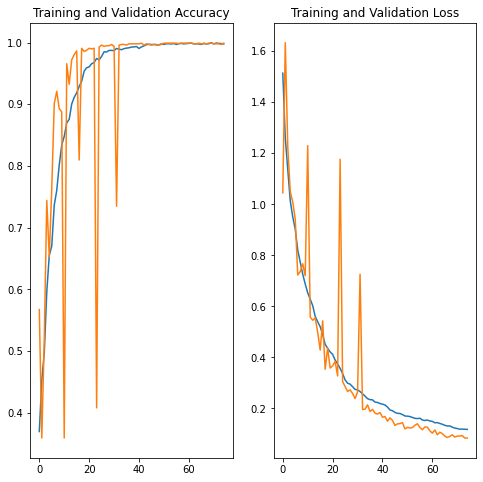

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
EPOCHS = 75
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()

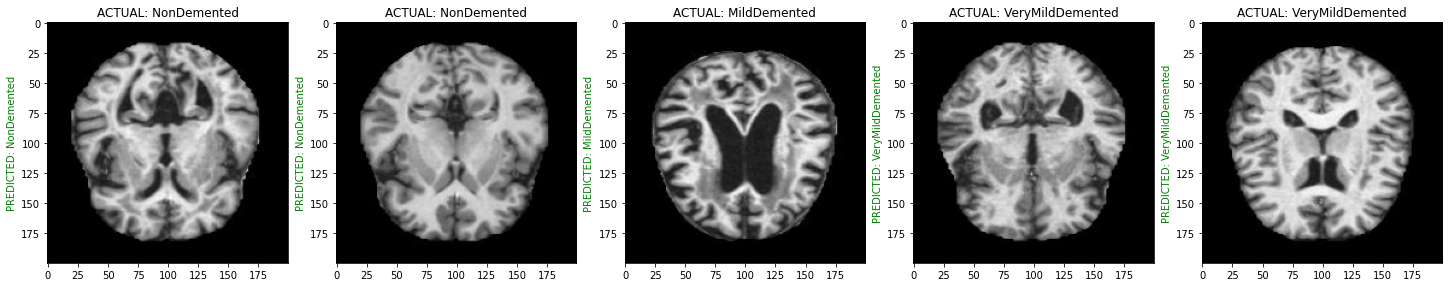

In [24]:
plt.figure(figsize = (25, 25))

for images, labels in test_data.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    
    plt.imshow(images[i].numpy().astype("uint8"))
    pred = model.predict(tf.expand_dims(images[i], 0))
    score = tf.nn.softmax(pred[0])
    if(CLASSES[labels[i]] == CLASSES[np.argmax(score)]):
      plt.title('ACTUAL: ' + CLASSES[labels[i]])
      plt.ylabel('PREDICTED: ' + CLASSES[np.argmax(score)], fontdict = {'color':'green'})
    else:
      plt.title('ACTUAL: ' + CLASSES[labels[i]])
      plt.ylabel('PREDICTED: ' + CLASSES[np.argmax(score)], fontdict = {'color':'red'})

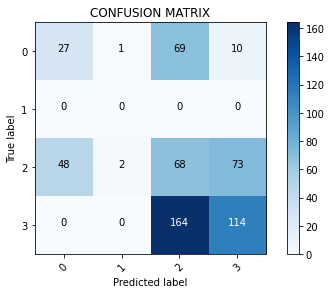

In [27]:
from sklearn.metrics import confusion_matrix
import itertools

#making a confusion matrixes
def plot_cm(cm, classes, normalize = False, title = 'CONFUSION MATRIX', cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
      else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(test_data)

y_pred_class = np.argmax(y_pred, axis = 1)

y_val = []
for _, label in test_data:
  for i in label:
    y_val.append(label[i].numpy())

# y_true = np.argmax(dataset)
# print(y_true)

confusion_mtx = confusion_matrix(y_val, y_pred_class) 

plot_cm(confusion_mtx, classes = range(4))


In [26]:
tf.keras.models.save_model(model, "predict.hdf5")